### Download Flower

In [ ]:
%%capture

!pip install flwr[simulation]==1.0.0
# wrote our own version of dataset_utils.py
#!wget https://raw.githubusercontent.com/adap/flower/v1.0.0/examples/simulation_pytorch/dataset_utils.py
!wget https://raw.githubusercontent.com/adap/flower/v1.0.0/baselines/flwr_baselines/dataset/utils/common.py

In [ ]:
%%writefile dataset_utils.py

from pathlib import Path
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import shutil
from PIL import Image
from torchvision.datasets import VisionDataset
from typing import Callable, Optional, Tuple, Any
from common import create_lda_partitions
import os

def get_dataset(path_to_data: Path, cid: str, partition: str):

    # generate path to cid's data
    path_to_data = path_to_data / cid / (partition + ".pt")

    return TorchVision_FL(path_to_data, transform=eurosatTransformation())


def get_dataloader(
    path_to_data: str, cid: str, is_train: bool, batch_size: int, workers: int
):
    """Generates trainset/valset object and returns appropiate dataloader."""

    partition = "train" if is_train else "val"
    dataset = get_dataset(Path(path_to_data), cid, partition)

    # we use as number of workers all the cpu cores assigned to this actor
    kwargs = {"num_workers": workers, "pin_memory": True, "drop_last": False}
    return DataLoader(dataset, batch_size=batch_size, **kwargs)


def get_random_id_splits(total: int, val_ratio: float, shuffle: bool = True):
    """splits a list of length `total` into two following a
    (1-val_ratio):val_ratio partitioning.

    By default the indices are shuffled before creating the split and
    returning.
    """

    if isinstance(total, int):
        indices = list(range(total))
    else:
        indices = total

    split = int(np.floor(val_ratio * len(indices)))
    # print(f"Users left out for validation (ratio={val_ratio}) = {split} ")
    if shuffle:
        np.random.shuffle(indices)
    return indices[split:], indices[:split]


def do_fl_partitioning(path_to_dataset, pool_size, alpha, num_classes, val_ratio=0.0):
    """Torchvision (e.g. CIFAR-10) datasets using LDA."""

    images, labels = torch.load(path_to_dataset)

    idx = np.array(range(len(images)))
    dataset = [idx, labels]

    # get the indices of the items for each partition using LDA
    partitions, _ = create_lda_partitions(
        dataset, num_partitions=pool_size, concentration=alpha, accept_imbalanced=True
    )

    # Show label distribution for first partition (purely informative)
    partition_zero = partitions[0][1]
    hist, _ = np.histogram(partition_zero, bins=list(range(num_classes + 1)))
    print(
        f"Class histogram for 0-th partition (alpha={alpha}, {num_classes} classes): {hist}"
    )

    # now save partitioned dataset to disk
    # first delete dir containing splits (if exists), then create it
    splits_dir = path_to_dataset.parent / "federated"
    if splits_dir.exists():
        shutil.rmtree(splits_dir)
    Path.mkdir(splits_dir, parents=True)

    for p in range(pool_size):

        labels = partitions[p][1]
        image_idx = partitions[p][0]
        imgs = images[image_idx]

        # create dir
        Path.mkdir(splits_dir / str(p))

        if val_ratio > 0.0:
            # split data according to val_ratio
            train_idx, val_idx = get_random_id_splits(len(labels), val_ratio)
            val_imgs = imgs[val_idx]
            val_labels = labels[val_idx]

            with open(splits_dir / str(p) / "val.pt", "wb") as f:
                torch.save([val_imgs, val_labels], f)

            # remaining images for training
            imgs = imgs[train_idx]
            labels = labels[train_idx]

        with open(splits_dir / str(p) / "train.pt", "wb") as f:
            torch.save([imgs, labels], f)

    return splits_dir


def cifar10Transformation():

    return transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

def eurosatTransformation():

    return transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.3444, 0.3803, 0.4078), (0.2027, 0.1369, 0.1156)),
        ]
    )

class TorchVision_FL(VisionDataset):
    """This is just a trimmed down version of torchvision.datasets.MNIST.

    Use this class by either passing a path to a torch file (.pt)
    containing (data, targets) or pass the data, targets directly
    instead.
    """

    def __init__(
        self,
        path_to_data=None,
        data=None,
        targets=None,
        transform: Optional[Callable] = None,
    ) -> None:
        path = path_to_data.parent if path_to_data else None
        super(TorchVision_FL, self).__init__(path, transform=transform)
        self.transform = transform

        if path_to_data:
            # load data and targets (path_to_data points to an specific .pt file)
            self.data, self.targets = torch.load(path_to_data)
        else:
            self.data = data
            self.targets = targets

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        if not isinstance(img, Image.Image):  # if not PIL image
            if not isinstance(img, np.ndarray):  # if torch tensor
                img = img.numpy()

            img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        return len(self.data)


def get_cifar_10(path_to_data="./data"):
    """Downloads CIFAR10 dataset and generates a unified training set (it will
    be partitioned later using the LDA partitioning mechanism."""

    # download dataset and load train set
    train_set = datasets.CIFAR10(root=path_to_data, train=True, download=True)

    # fuse all data splits into a single "training.pt"
    data_loc = Path(path_to_data) / "cifar-10-batches-py"
    training_data = data_loc / "training.pt"
    print("Generating unified CIFAR dataset")
    torch.save([train_set.data, np.array(train_set.targets)], training_data)

    test_set = datasets.CIFAR10(
        root=path_to_data, train=False, transform=cifar10Transformation()
    )

    # returns path where training data is and testset
    return training_data, test_set

def get_eurosat(path_to_data="./eurosat_data"):

    # download and split dataset into train and test sets
    eurosat_dataset = datasets.EuroSAT("./eurosat_data", download=True, transform=eurosatTransformation())

    train_set, test_set = random_split(eurosat_dataset, [24000, 3000], torch.Generator().manual_seed(42))

    # load all of the training images so we can combine them into a single PyTorch file (.pt)
    train_set_data: Any = []

    base_folder = "eurosat/2750"
    path_list = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]

    for folder in path_list:
        folder_path = os.path.join(path_to_data, base_folder, folder)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            img = np.array(Image.open(file_path))
            train_set_data.append(img)

    train_set_data = np.array(train_set_data) # convert into numpy array of shape (N, H, W, C)

    # fuse all data splits into a single dataset named "training.pt"
    data_loc = Path(path_to_data) / "eurosat"
    training_data_path = data_loc / "training.pt"
    torch.save([train_set_data, np.array(train_set.dataset.targets)], training_data_path)

    return training_data_path, test_set



Writing dataset_utils.py


In [ ]:
%%writefile fedavg.py

from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy

from numpy import random

from aggregate import aggregate, aggregate_inplace, weighted_loss_avg
from strategy import Strategy

WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW = """
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.
"""


# pylint: disable=line-too-long
class FedAvg(Strategy):
    """Federated Averaging strategy.

    Implementation based on https://arxiv.org/abs/1602.05629

    Parameters
    ----------
    fraction_fit : float, optional
        Fraction of clients used during training. In case `min_fit_clients`
        is larger than `fraction_fit * available_clients`, `min_fit_clients`
        will still be sampled. Defaults to 1.0.
    fraction_evaluate : float, optional
        Fraction of clients used during validation. In case `min_evaluate_clients`
        is larger than `fraction_evaluate * available_clients`,
        `min_evaluate_clients` will still be sampled. Defaults to 1.0.
    min_fit_clients : int, optional
        Minimum number of clients used during training. Defaults to 2.
    min_evaluate_clients : int, optional
        Minimum number of clients used during validation. Defaults to 2.
    min_available_clients : int, optional
        Minimum number of total clients in the system. Defaults to 2.
    evaluate_fn : Optional[Callable[[int, NDArrays, Dict[str, Scalar]],Optional[Tuple[float, Dict[str, Scalar]]]]]
        Optional function used for validation. Defaults to None.
    on_fit_config_fn : Callable[[int], Dict[str, Scalar]], optional
        Function used to configure training. Defaults to None.
    on_evaluate_config_fn : Callable[[int], Dict[str, Scalar]], optional
        Function used to configure validation. Defaults to None.
    accept_failures : bool, optional
        Whether or not accept rounds containing failures. Defaults to True.
    initial_parameters : Parameters, optional
        Initial global model parameters.
    fit_metrics_aggregation_fn : Optional[MetricsAggregationFn]
        Metrics aggregation function, optional.
    evaluate_metrics_aggregation_fn : Optional[MetricsAggregationFn]
        Metrics aggregation function, optional.
    """

    # pylint: disable=too-many-arguments,too-many-instance-attributes, line-too-long
    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
    ) -> None:
        super().__init__()

        if (
            min_fit_clients > min_available_clients
            or min_evaluate_clients > min_available_clients
        ):
            log(WARNING, WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW)

        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

    def __repr__(self) -> str:
        """Compute a string representation of the strategy."""
        rep = f"FedAvg(accept_failures={self.accept_failures})"
        return rep

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return the sample size and the required number of available clients."""
        modded_fraction_fit = random.randint(30, 100) / 100 # changed this to get random numbers of clients per round
        num_clients = int(num_available_clients * modded_fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        initial_parameters = self.initial_parameters
        self.initial_parameters = None  # Don't keep initial parameters in memory
        return initial_parameters

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        if self.on_fit_config_fn is not None:
            # Custom fit config function provided
            config = self.on_fit_config_fn(server_round)
        fit_ins = FitIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, fit_ins) for client in clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        # Do not configure federated evaluation if fraction eval is 0.
        if self.fraction_evaluate == 0.0:
            return []

        # Parameters and config
        config = {}
        if self.on_evaluate_config_fn is not None:
            # Custom evaluation config function provided
            config = self.on_evaluate_config_fn(server_round)
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        if self.inplace:
            # Does in-place weighted average of results
            aggregated_ndarrays = aggregate_inplace(results)
        else:
            # Convert results
            weights_results = [
                (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
                for _, fit_res in results
            ]
            aggregated_ndarrays = aggregate(weights_results)

        parameters_aggregated = ndarrays_to_parameters(aggregated_ndarrays)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Aggregate loss
        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.evaluate_metrics_aggregation_fn:
            eval_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.evaluate_metrics_aggregation_fn(eval_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No evaluate_metrics_aggregation_fn provided")

        return loss_aggregated, metrics_aggregated

Writing fedavg.py


In [ ]:
%%writefile strategy.py

from abc import ABC, abstractmethod
from typing import Dict, List, Optional, Tuple, Union

from flwr.common import EvaluateIns, EvaluateRes, FitIns, FitRes, Parameters, Scalar
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy


class Strategy(ABC):
    """Abstract base class for server strategy implementations."""

    @abstractmethod
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize the (global) model parameters.

        Parameters
        ----------
        client_manager : ClientManager
            The client manager which holds all currently connected clients.

        Returns
        -------
        parameters : Optional[Parameters]
            If parameters are returned, then the server will treat these as the
            initial global model parameters.
        """

    @abstractmethod
    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Parameters
        ----------
        server_round : int
            The current round of federated learning.
        parameters : Parameters
            The current (global) model parameters.
        client_manager : ClientManager
            The client manager which holds all currently connected clients.

        Returns
        -------
        fit_configuration : List[Tuple[ClientProxy, FitIns]]
            A list of tuples. Each tuple in the list identifies a `ClientProxy` and the
            `FitIns` for this particular `ClientProxy`. If a particular `ClientProxy`
            is not included in this list, it means that this `ClientProxy`
            will not participate in the next round of federated learning.
        """

    @abstractmethod
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate training results.

        Parameters
        ----------
        server_round : int
            The current round of federated learning.
        results : List[Tuple[ClientProxy, FitRes]]
            Successful updates from the previously selected and configured
            clients. Each pair of `(ClientProxy, FitRes)` constitutes a
            successful update from one of the previously selected clients. Not
            that not all previously selected clients are necessarily included in
            this list: a client might drop out and not submit a result. For each
            client that did not submit an update, there should be an `Exception`
            in `failures`.
        failures : List[Union[Tuple[ClientProxy, FitRes], BaseException]]
            Exceptions that occurred while the server was waiting for client
            updates.

        Returns
        -------
        parameters : Tuple[Optional[Parameters], Dict[str, Scalar]]
            If parameters are returned, then the server will treat these as the
            new global model parameters (i.e., it will replace the previous
            parameters with the ones returned from this method). If `None` is
            returned (e.g., because there were only failures and no viable
            results) then the server will no update the previous model
            parameters, the updates received in this round are discarded, and
            the global model parameters remain the same.
        """

    @abstractmethod
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation.

        Parameters
        ----------
        server_round : int
            The current round of federated learning.
        parameters : Parameters
            The current (global) model parameters.
        client_manager : ClientManager
            The client manager which holds all currently connected clients.

        Returns
        -------
        evaluate_configuration : List[Tuple[ClientProxy, EvaluateIns]]
            A list of tuples. Each tuple in the list identifies a `ClientProxy` and the
            `EvaluateIns` for this particular `ClientProxy`. If a particular
            `ClientProxy` is not included in this list, it means that this
            `ClientProxy` will not participate in the next round of federated
            evaluation.
        """

    @abstractmethod
    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation results.

        Parameters
        ----------
        server_round : int
            The current round of federated learning.
        results : List[Tuple[ClientProxy, FitRes]]
            Successful updates from the
            previously selected and configured clients. Each pair of
            `(ClientProxy, FitRes` constitutes a successful update from one of the
            previously selected clients. Not that not all previously selected
            clients are necessarily included in this list: a client might drop out
            and not submit a result. For each client that did not submit an update,
            there should be an `Exception` in `failures`.
        failures : List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
            Exceptions that occurred while the server was waiting for client updates.

        Returns
        -------
        aggregation_result : Tuple[Optional[float], Dict[str, Scalar]]
            The aggregated evaluation result. Aggregation typically uses some variant
            of a weighted average.
        """

    @abstractmethod
    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate the current model parameters.

        This function can be used to perform centralized (i.e., server-side) evaluation
        of model parameters.

        Parameters
        ----------
        server_round : int
            The current round of federated learning.
        parameters: Parameters
            The current (global) model parameters.

        Returns
        -------
        evaluation_result : Optional[Tuple[float, Dict[str, Scalar]]]
            The evaluation result, usually a Tuple containing loss and a
            dictionary containing task-specific metrics (e.g., accuracy).
        """

Writing strategy.py


In [ ]:
%%writefile aggregate.py

from functools import reduce
from typing import Any, Callable, List, Tuple

import numpy as np

from flwr.common import FitRes, NDArray, NDArrays, parameters_to_ndarrays
from flwr.server.client_proxy import ClientProxy


def aggregate(results: List[Tuple[NDArrays, int]]) -> NDArrays:
    """Compute weighted average."""
    # Calculate the total number of examples used during training
    num_examples_total = sum([num_examples for _, num_examples in results])

    # Create a list of weights, each multiplied by the related number of examples
    weighted_weights = [
        [layer * num_examples for layer in weights] for weights, num_examples in results
    ]

    # Compute average weights of each layer
    weights_prime: NDArrays = [
        reduce(np.add, layer_updates) / num_examples_total
        for layer_updates in zip(*weighted_weights)
    ]
    return weights_prime


def aggregate_inplace(results: List[Tuple[ClientProxy, FitRes]]) -> NDArrays:
    """Compute in-place weighted average."""
    # Count total examples
    num_examples_total = sum([fit_res.num_examples for _, fit_res in results])

    # Compute scaling factors for each result
    scaling_factors = [
        fit_res.num_examples / num_examples_total for _, fit_res in results
    ]

    # Let's do in-place aggregation
    # Get first result, then add up each other
    params = [
        scaling_factors[0] * x for x in parameters_to_ndarrays(results[0][1].parameters)
    ]
    for i, (_, fit_res) in enumerate(results[1:]):
        res = (
            scaling_factors[i + 1] * x
            for x in parameters_to_ndarrays(fit_res.parameters)
        )
        params = [reduce(np.add, layer_updates) for layer_updates in zip(params, res)]

    return params


def aggregate_median(results: List[Tuple[NDArrays, int]]) -> NDArrays:
    """Compute median."""
    # Create a list of weights and ignore the number of examples
    weights = [weights for weights, _ in results]

    # Compute median weight of each layer
    median_w: NDArrays = [
        np.median(np.asarray(layer), axis=0) for layer in zip(*weights)
    ]
    return median_w


def aggregate_krum(
    results: List[Tuple[NDArrays, int]], num_malicious: int, to_keep: int
) -> NDArrays:
    """Choose one parameter vector according to the Krum function.

    If to_keep is not None, then MultiKrum is applied.
    """
    # Create a list of weights and ignore the number of examples
    weights = [weights for weights, _ in results]

    # Compute distances between vectors
    distance_matrix = _compute_distances(weights)

    # For each client, take the n-f-2 closest parameters vectors
    num_closest = max(1, len(weights) - num_malicious - 2)
    closest_indices = []
    for i, _ in enumerate(distance_matrix):
        closest_indices.append(
            np.argsort(distance_matrix[i])[1 : num_closest + 1].tolist()  # noqa: E203
        )

    # Compute the score for each client, that is the sum of the distances
    # of the n-f-2 closest parameters vectors
    scores = [
        np.sum(distance_matrix[i, closest_indices[i]])
        for i in range(len(distance_matrix))
    ]

    if to_keep > 0:
        # Choose to_keep clients and return their average (MultiKrum)
        best_indices = np.argsort(scores)[::-1][len(scores) - to_keep :]  # noqa: E203
        best_results = [results[i] for i in best_indices]
        return aggregate(best_results)

    # Return the model parameters that minimize the score (Krum)
    return weights[np.argmin(scores)]


# pylint: disable=too-many-locals
def aggregate_bulyan(
    results: List[Tuple[NDArrays, int]],
    num_malicious: int,
    aggregation_rule: Callable,  # type: ignore
    **aggregation_rule_kwargs: Any,
) -> NDArrays:
    """Perform Bulyan aggregation.

    Parameters
    ----------
    results: List[Tuple[NDArrays, int]]
        Weights and number of samples for each of the client.
    num_malicious: int
        The maximum number of malicious clients.
    aggregation_rule: Callable
        Byzantine resilient aggregation rule used as the first step of the Bulyan
    aggregation_rule_kwargs: Any
        The arguments to the aggregation rule.

    Returns
    -------
    aggregated_parameters: NDArrays
        Aggregated parameters according to the Bulyan strategy.
    """
    byzantine_resilient_single_ret_model_aggregation = [aggregate_krum]
    # also GeoMed (but not implemented yet)
    byzantine_resilient_many_return_models_aggregation = []  # type: ignore
    # Brute, Medoid (but not implemented yet)

    num_clients = len(results)
    if num_clients < 4 * num_malicious + 3:
        raise ValueError(
            "The Bulyan aggregation requires then number of clients to be greater or "
            "equal to the 4 * num_malicious + 3. This is the assumption of this method."
            "It is needed to ensure that the method reduces the attacker's leeway to "
            "the one proved in the paper."
        )
    selected_models_set: List[Tuple[NDArrays, int]] = []

    theta = len(results) - 2 * num_malicious
    beta = theta - 2 * num_malicious

    for _ in range(theta):
        best_model = aggregation_rule(
            results=results, num_malicious=num_malicious, **aggregation_rule_kwargs
        )
        list_of_weights = [weights for weights, num_samples in results]
        # This group gives exact result
        if aggregation_rule in byzantine_resilient_single_ret_model_aggregation:
            best_idx = _find_reference_weights(best_model, list_of_weights)
        # This group requires finding the closest model to the returned one
        # (weights distance wise)
        elif aggregation_rule in byzantine_resilient_many_return_models_aggregation:
            # when different aggregation strategies available
            # write a function to find the closest model
            raise NotImplementedError(
                "aggregate_bulyan currently does not support the aggregation rules that"
                " return many models as results. "
                "Such aggregation rules are currently not available in Flower."
            )
        else:
            raise ValueError(
                "The given aggregation rule is not added as Byzantine resilient. "
                "Please choose from Byzantine resilient rules."
            )

        selected_models_set.append(results[best_idx])

        # remove idx from tracker and weights_results
        results.pop(best_idx)

    # Compute median parameter vector across selected_models_set
    median_vect = aggregate_median(selected_models_set)

    # Take the averaged beta parameters of the closest distance to the median
    # (coordinate-wise)
    parameters_aggregated = _aggregate_n_closest_weights(
        median_vect, selected_models_set, beta_closest=beta
    )
    return parameters_aggregated


def weighted_loss_avg(results: List[Tuple[int, float]]) -> float:
    """Aggregate evaluation results obtained from multiple clients."""
    num_total_evaluation_examples = sum([num_examples for num_examples, _ in results])
    weighted_losses = [num_examples * loss for num_examples, loss in results]
    return sum(weighted_losses) / num_total_evaluation_examples


def aggregate_qffl(
    parameters: NDArrays, deltas: List[NDArrays], hs_fll: List[NDArrays]
) -> NDArrays:
    """Compute weighted average based on Q-FFL paper."""
    demominator: float = np.sum(np.asarray(hs_fll))
    scaled_deltas = []
    for client_delta in deltas:
        scaled_deltas.append([layer * 1.0 / demominator for layer in client_delta])
    updates = []
    for i in range(len(deltas[0])):
        tmp = scaled_deltas[0][i]
        for j in range(1, len(deltas)):
            tmp += scaled_deltas[j][i]
        updates.append(tmp)
    new_parameters = [(u - v) * 1.0 for u, v in zip(parameters, updates)]
    return new_parameters


def _compute_distances(weights: List[NDArrays]) -> NDArray:
    """Compute distances between vectors.

    Input: weights - list of weights vectors
    Output: distances - matrix distance_matrix of squared distances between the vectors
    """
    flat_w = np.array([np.concatenate(p, axis=None).ravel() for p in weights])
    distance_matrix = np.zeros((len(weights), len(weights)))
    for i, _ in enumerate(flat_w):
        for j, _ in enumerate(flat_w):
            delta = flat_w[i] - flat_w[j]
            norm = np.linalg.norm(delta)
            distance_matrix[i, j] = norm**2
    return distance_matrix


def _trim_mean(array: NDArray, proportiontocut: float) -> NDArray:
    """Compute trimmed mean along axis=0.

    It is based on the scipy implementation.

    https://docs.scipy.org/doc/scipy/reference/generated/
    scipy.stats.trim_mean.html.
    """
    axis = 0
    nobs = array.shape[axis]
    lowercut = int(proportiontocut * nobs)
    uppercut = nobs - lowercut
    if lowercut > uppercut:
        raise ValueError("Proportion too big.")

    atmp = np.partition(array, (lowercut, uppercut - 1), axis)

    slice_list = [slice(None)] * atmp.ndim
    slice_list[axis] = slice(lowercut, uppercut)
    result: NDArray = np.mean(atmp[tuple(slice_list)], axis=axis)
    return result


def aggregate_trimmed_avg(
    results: List[Tuple[NDArrays, int]], proportiontocut: float
) -> NDArrays:
    """Compute trimmed average."""
    # Create a list of weights and ignore the number of examples
    weights = [weights for weights, _ in results]

    trimmed_w: NDArrays = [
        _trim_mean(np.asarray(layer), proportiontocut=proportiontocut)
        for layer in zip(*weights)
    ]

    return trimmed_w


def _check_weights_equality(weights1: NDArrays, weights2: NDArrays) -> bool:
    """Check if weights are the same."""
    if len(weights1) != len(weights2):
        return False
    return all(
        np.array_equal(layer_weights1, layer_weights2)
        for layer_weights1, layer_weights2 in zip(weights1, weights2)
    )


def _find_reference_weights(
    reference_weights: NDArrays, list_of_weights: List[NDArrays]
) -> int:
    """Find the reference weights by looping through the `list_of_weights`.

    Raise Error if the reference weights is not found.

    Parameters
    ----------
    reference_weights: NDArrays
        Weights that will be searched for.
    list_of_weights: List[NDArrays]
        List of weights that will be searched through.

    Returns
    -------
    index: int
        The index of `reference_weights` in the `list_of_weights`.

    Raises
    ------
    ValueError
        If `reference_weights` is not found in `list_of_weights`.
    """
    for idx, weights in enumerate(list_of_weights):
        if _check_weights_equality(reference_weights, weights):
            return idx
    raise ValueError("The reference weights not found in list_of_weights.")


def _aggregate_n_closest_weights(
    reference_weights: NDArrays, results: List[Tuple[NDArrays, int]], beta_closest: int
) -> NDArrays:
    """Calculate element-wise mean of the `N` closest values.

    Note, each i-th coordinate of the result weight is the average of the beta_closest
    -ith coordinates to the reference weights


    Parameters
    ----------
    reference_weights: NDArrays
        The weights from which the distances will be computed
    results: List[Tuple[NDArrays, int]]
        The weights from models
    beta_closest: int
        The number of the closest distance weights that will be averaged

    Returns
    -------
    aggregated_weights: NDArrays
        Averaged (element-wise) beta weights that have the closest distance to
         reference weights
    """
    list_of_weights = [weights for weights, num_examples in results]
    aggregated_weights = []

    for layer_id, layer_weights in enumerate(reference_weights):
        other_weights_layer_list = []
        for other_w in list_of_weights:
            other_weights_layer = other_w[layer_id]
            other_weights_layer_list.append(other_weights_layer)
        other_weights_layer_np = np.array(other_weights_layer_list)
        diff_np = np.abs(layer_weights - other_weights_layer_np)
        # Create indices of the smallest differences
        # We do not need the exact order but just the beta closest weights
        # therefore np.argpartition is used instead of np.argsort
        indices = np.argpartition(diff_np, kth=beta_closest - 1, axis=0)
        # Take the weights (coordinate-wise) corresponding to the beta of the
        # closest distances
        beta_closest_weights = np.take_along_axis(
            other_weights_layer_np, indices=indices, axis=0
        )[:beta_closest]
        aggregated_weights.append(np.mean(beta_closest_weights, axis=0))
    return aggregated_weights

Writing aggregate.py


In [ ]:
%%writefile simple_cnn.py

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Optional

import flwr as fl
import numpy as np

class Net(nn.Module):
    """Simple CNN adapted from 'PyTorch: A 60 Minute Blitz'."""

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 2704) # change to match the dimension of prev layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_weights(self) -> fl.common.NDArrays:
        """Get model weights as a list of NumPy ndarrays."""
        return [val.cpu().numpy() for _, val in self.state_dict().items()]

    def set_weights(self, weights: fl.common.NDArrays) -> None:
        """Set model weight s from a list of NumPy ndarrays."""
        state_dict = OrderedDict(
            {k: torch.Tensor(v) for k, v in zip(self.state_dict().keys(), weights)}
        )
        self.load_state_dict(state_dict, strict=True)

def train(
    net: Net,
    trainloader: DataLoader,
    device: torch.device,
    num_iterations: int,
    log_progress: bool = True,
    optim='SGD'):

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()

    if optim == 'SGD':
      optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optim == 'Adam':
      optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


    def cycle(iterable):
        """Repeats the contents of the train loader, in case it gets exhausted in 'num_iterations'."""
        while True:
            for x in iterable:
                yield x

    # Train the network
    net.train()
    total_loss, total_correct, n_samples = 0.0, 0.0, 0
    pbar = tqdm(iter(cycle(trainloader)), total=num_iterations, desc=f'TRAIN') if log_progress else iter(cycle(trainloader))

    # Unusually, this training is formulated in terms of number of updates/iterations/batches processed
    # by the network. This will be helpful later on, when partitioning the data across clients: resulting
    # in differences between dataset sizes and hence inconsistent numbers of updates per 'epoch'.
    for i, data in zip(range(num_iterations), pbar):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Collected training loss and accuracy statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        if log_progress:
            pbar.set_postfix({
                "train_loss": total_loss/n_samples,
                "train_acc": total_correct/n_samples
            })
    if log_progress:
        print("\n")

    return total_loss/n_samples, total_correct/n_samples, n_samples

def test(
    net: Net,
    testloader: DataLoader,
    device: torch.device,
    log_progress: bool = True):
    """Evaluates the network on test data."""
    criterion = nn.CrossEntropyLoss()

    num_classes = 10
    total_loss, total_correct, n_samples = 0.0, 0.0, 0

    net.eval()

    # for calculating precision and recall metrics
    total_true = np.zeros(num_classes) # array to store total instances of each class
    total_pred = np.zeros(num_classes) # array to store total predictions of each class
    total_tp = np.zeros(num_classes) # array to store total true positives of each class

    len_testset = len(testloader.dataset)

    with torch.no_grad():
        pbar = tqdm(testloader, desc="TEST") if log_progress else testloader
        for data in pbar:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)

            # Collected testing loss and accuracy statistics
            total_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item() # number of true positives

            # count instances of actual, predicted and the true positives for each class
            where_correct = (predicted == labels)
            true_positives = predicted[where_correct]
            for cls_idx in range(num_classes):
                total_true[cls_idx] += (labels == cls_idx).sum().item() # total true (actual) instances of current class
                total_pred[cls_idx] += (predicted == cls_idx).sum().item() # total predicted instances of current class
                total_tp[cls_idx] += (true_positives == cls_idx).sum().item() # true positive predictions of current class

    precisions = total_tp / total_pred
    recalls = total_tp / total_true
    proportions = total_true / len_testset

    if log_progress:
        print("\n")

    return total_loss/n_samples, total_correct/n_samples, n_samples, precisions, recalls, proportions


Writing simple_cnn.py


In [ ]:
%%writefile client.py

from typing import Optional
from pathlib import Path

import flwr as fl
import torch
from torch.utils.data import DataLoader
from flwr.common import EvaluateIns, EvaluateRes, FitIns, FitRes, GetPropertiesIns, GetPropertiesRes, GetParametersIns, \
    GetParametersRes, Status, Code, parameters_to_ndarrays, ndarrays_to_parameters

from simple_cnn import Net, train, test
from dataset_utils import get_dataset


def get_dataloader(path_to_data: str, cid: str, partition: str, batch_size: int):
    """Generates trainset/valset object and returns appropiate dataloader."""
    dataset = get_dataset(Path(path_to_data), cid, partition)
    return DataLoader(dataset, batch_size=batch_size, pin_memory=True,
                      shuffle=(partition == "train"))


class EuroSATClient(fl.client.Client):
    def __init__(self, cid: str, fed_data_dir: str, log_progress: bool = False):
        """
        Creates a client for training `network.Net` on CIFAR-10.

        Args:
            cid: A unique ID given to the client (typically a number)
            fed_data_dir: A path to a partitioned dataset
            log_progress: Controls whether clients log their progress
        """
        self.cid = cid
        self.data_dir = fed_data_dir
        self.properties = {"tensor_type": "numpy.ndarray"}
        self.log_progress = log_progress
        # Initilise the `net`` variable to `None`
        self.net = None

        # determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def get_properties(self, ins: GetPropertiesIns):
        return GetPropertiesRes(properties=self.properties)

    def get_parameters(self, ins: GetParametersIns):
        if self.net is None:
            self.net = Net()
        return GetParametersRes(status=Status(Code.OK, ""), parameters=ndarrays_to_parameters(self.net.get_weights()))

    def set_parameters(self, parameters):
        if self.net is None:
            self.net = Net()
        self.net.set_weights(parameters_to_ndarrays(parameters))

    def fit(self, fit_params: FitIns) -> FitRes:
        # Instantiate model (best practise)
        self.net = Net()
        # Process incoming request to train
        batch_size = fit_params.config["batch_size"]
        num_iterations = fit_params.config["num_iterations"]
        self.set_parameters(fit_params.parameters)

        # Initialise data loader
        trainloader = get_dataloader(
            path_to_data=self.data_dir,
            cid=self.cid,
            partition="train",
            batch_size=batch_size)

        # num_iterations = None special behaviour: train(...) runs for a single epoch, however many updates it may be
        num_iterations = num_iterations or len(trainloader)

        # Train the model
        print(f"Client {self.cid}: training for {num_iterations} iterations/updates")
        self.net.to(self.device)
        train_loss, train_acc, num_examples = \
            train(self.net, trainloader,
                  device=self.device,
                  num_iterations=num_iterations,
                  log_progress=self.log_progress,
                  optim='Adam')
        print(f"Client {self.cid}: training round complete, {num_examples} examples processed")

        # Return training information: model, number of examples processed and metrics
        return FitRes(
            status=Status(Code.OK, ""),
            parameters=self.get_parameters(fit_params.config).parameters,
            num_examples=num_examples,
            metrics={"loss": train_loss, "accuracy": train_acc})

    def evaluate(self, eval_params: EvaluateIns) -> EvaluateRes:
        # Process incoming request to evaluate
        batch_size = eval_params.config["batch_size"]
        self.set_parameters(eval_params.parameters)

        # Initialise data loader
        valloader = get_dataloader(
            path_to_data=self.data_dir,
            cid=self.cid,
            partition="val",
            batch_size=batch_size)

        # Evaluate the model
        self.net.to(self.device)
        loss, accuracy, num_examples, _, _, _ = test(self.net, valloader, device=self.device, log_progress=self.log_progress)

        print(f"Client {self.cid}: evaluation on {num_examples} examples: loss={loss:.4f}, accuracy={accuracy:.4f}")
        # Return evaluation information
        return EvaluateRes(
            status=Status(Code.OK, ""),
            loss=loss, num_examples=num_examples,
            metrics={"accuracy": accuracy})

Writing client.py


In [ ]:
%%writefile server.py

import argparse
import functools

import flwr as fl
import torch
import click
from torch.utils.data import DataLoader
#from flwr.server.strategy import FedAvg
from flwr.server.app import ServerConfig
from flwr.common import NDArrays

from dataset_utils import get_eurosat, do_fl_partitioning
from simple_cnn import Net, test
from client import EuroSATClient
from fedavg import FedAvg

def serverside_eval(server_round, parameters: NDArrays, config, testloader):
    """An evaluation function for centralized/serverside evaluation over the entire EuroSAT test set."""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Net()
    model.set_weights(parameters)
    model.to(device)
    loss, accuracy, _, precisions, recalls, proportions = test(model, testloader, device=device, log_progress=False)
    print(f"Evaluation on the server: test_loss={loss:.4f}, test_accuracy={accuracy:.4f}")
    return loss, {"accuracy": accuracy, "precisions": precisions, "recalls": recalls, "class proportions": proportions}


@click.command()
@click.option("--num-rounds", default=10, help="The number of rounds in the FL experiment")
@click.option("--client-pool-size", default=5, help="The number of clients made available to an FL round")
@click.option("--num-iterations", default=None, type=int,
              help="Number of iterations/updates a client performs per round (single local epoch if None)")
@click.option("--fraction-fit", default=1.0,
              help="Controls what fraction of clients should be sampled for an FL fitting round.")
@click.option("--min-fit-clients", default=2,
              help="The minimum number of clients to participate in a fitting round (regardless of 'fraction_fit')")
@click.option("--batch-size", default=32, help="Batch size for a client fitting round")
@click.option("--val-ratio", default=0.1, help="Proportion of local data to reserve as a local test set")
@click.option("--iid-alpha", default=1000.0, help="LDA prior concentration parameter for data partitioning")
def start_experiment(
    num_rounds=10,
    client_pool_size=5,
    num_iterations=None,
    fraction_fit=1.0,
    min_fit_clients=2,
    batch_size=32,
    val_ratio=0.1,
    iid_alpha=1000.0):
    client_resources = {"num_cpus": 0.5}  # 2 clients per CPU

    # Download the EuroSAT dataset
    train_path, testset = get_eurosat()

    # Partition the dataset into subsets reserved for each client.
    # - to control the degree of IID: use a large `alpha` to make it IID; a small value (e.g. 1) will make it non-IID
    # - 'val_ratio' controls the proportion of the (local) client reserved as a local test set
    # (good for testing how the final model performs on the client's local unseen data)
    fed_data_dir = do_fl_partitioning(train_path, pool_size=client_pool_size,
                                      alpha=iid_alpha, num_classes=10, val_ratio=val_ratio)
    print(f"Data partitioned across {client_pool_size} clients, with IID alpha = {iid_alpha} "
          f"and {val_ratio} of local dataset reserved for validation.")

    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

    # Configure the strategy
    def fit_config(server_round: int):
        print(f"Configuring round {server_round}")

        # iterations = 16*x^2 + 6*x
        # (quadratically increase, total is 98830 iterations if num_rounds is 10)
        new_num_iterations = 16*server_round*server_round + 6*server_round

        return {
            "num_iterations": num_iterations,
            "batch_size": batch_size,
        }

    # FedAvg simply averages contributions from all clients
    strategy = FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_fit if val_ratio > 0.0 else 0.0,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_fit_clients,
        min_available_clients=client_pool_size,  # all clients should be available
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=(lambda r: {"batch_size": 100}),
        evaluate_fn=functools.partial(serverside_eval, testloader=testloader),
        accept_failures=False,
    )

    print(f"FL experiment configured for {num_rounds} rounds with {client_pool_size} client in the pool.")
    print(f"FL round will proceed with {fraction_fit * 100}% of clients sampled, at least {min_fit_clients}.")

    def client_fn(cid: str):
        """Creates a federated learning client"""
        return EuroSATClient(cid, fed_data_dir, log_progress=False)

    # Start the simulation
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=client_pool_size,
        client_resources=client_resources,
        config=ServerConfig(num_rounds=num_rounds),
        strategy=strategy)

    print(history)

    return history

if __name__ == "__main__":
    start_experiment()

Writing server.py


In [ ]:
from dataset_utils import get_eurosat
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
training_path, test_set = get_eurosat()

100%|██████████| 94280567/94280567 [00:01<00:00, 79882027.61it/s]


Extracting ./eurosat_data/eurosat/EuroSAT.zip to ./eurosat_data/eurosat


### VAE Model

Specified in network.py

The model is a VAE adapted from __RaVAEn - Unsupervised Distaster Management via Change Detection On-board Satellites__

In [ ]:
%%writefile model_vae.py

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import List, Any, Dict

import flwr as fl

class SimpleVAE(nn.Module):
    """Simple VAE adapted from 'RaVAEn - Unsupervised Distaster
    Management via Change Detection On-board Satellites'
    """

    def __init__(self, input_shape=(3, 32, 32), latent_dim=128, visualisation_channels=[2,1,0]):
        super(SimpleVAE, self).__init__()

        self.latent_dim = latent_dim
        self.visualisation_channels = visualisation_channels # maybe specific to ravaen dataset TODO
        self.input_shape = input_shape

        # Reconstructing things, so in and out channels should be the same (default is 10 channels for RaVAEn)
        in_channels = input_shape[0]
        out_channels = input_shape[0]

        # Defines encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 7),
            nn.LeakyReLU()
        )

        self.width = (input_shape[1] // 2) // 2 - 6

        # Encodes latent space, it's Linear. Latent dim = output features
        self.fc_mu = nn.Linear(256 * self.width * self.width, latent_dim)
        self.fc_var = nn.Linear(256 * self.width * self.width, latent_dim)

        self.decoder_input = \
            nn.Linear(latent_dim, 256 * self.width * self.width)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 7),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1,
                               output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, out_channels, 3, stride=2, padding=1,
                               output_padding=1),
        )


    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 256, self.width, self.width)
        result = self.decoder(result)
        return result


    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(torch.nan_to_num(input))
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), mu, log_var]

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """
        return self.forward(x)[0]

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1) - Normalises this
        :param mu: Mean of the latent Gaussian [B x D]
        :param logvar: Standard deviation of the latent Gaussian [B x D]
        :return: [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def get_weights(self) -> fl.common.NDArrays:
        """Get model weights as a list of NumPy ndarrays."""
        return [val.cpu().numpy() for _, val in self.state_dict().items()]

    def set_weights(self, weights: fl.common.NDArrays) -> None:
        """Set model weight s from a list of NumPy ndarrays."""
        state_dict = OrderedDict(
            {k: torch.Tensor(v) for k, v in zip(self.state_dict().keys(), weights)}
        )
        self.load_state_dict(state_dict, strict=True)

    def loss_function(self, input: Tensor, results: Any, **kwargs) -> Dict:
        """
        Computes the VAE loss function.

        :param args:
        :param kwargs:
        :return:
        """
        # invalid_mask = torch.isnan(input)
        input = torch.nan_to_num(input)

        recons = results[0]
        mu = results[1]
        log_var = results[2]

        # Account for the minibatch samples from the dataset
        kld_weight = 0.1

        recons_loss = F.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)

        # KLD weight is a hyperparameter, affects how much KLD loss govern training TODO experiment?
        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss, 'KLD': -kld_loss}
        #return {'loss': recons_loss, 'Reconstruction_Loss': recons_loss}

def train(
    net: SimpleVAE,
    trainloader: DataLoader,
    device: torch.device,
    num_iterations: int,
    log_progress: bool = True):
    # Define loss and optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

    def cycle(iterable):
        """Repeats the contents of the train loader, in case it gets exhausted in 'num_iterations'."""
        while True:
            for x in iterable:
                yield x

    # Train the network
    net.train()
    total_rec_loss, total_kld_loss, n_samples = 0.0, 0.0, 0
    pbar = tqdm(iter(cycle(trainloader)), total=num_iterations, desc=f'TRAIN') if log_progress else iter(cycle(trainloader))

    # Unusually, this training is formulated in terms of number of updates/iterations/batches processed
    # by the network. This will be helpful later on, when partitioning the data across clients: resulting
    # in differences between dataset sizes and hence inconsistent numbers of updates per 'epoch'.
    for i, data in zip(range(num_iterations), pbar):
        images = data[0].to(device)
        #labels = data[1].to(device)

        optimizer.zero_grad()

        # run the SimpleVAE forward() func to get reconstructed
        # images, as well as the mu's and vars
        recons_imgs = net(images)

        # compute loss function as defined in SimpleVAE
        loss = net.loss_function(images, recons_imgs)

        # training step
        loss['loss'].backward()
        optimizer.step()

        # Collected training loss and accuracy statistics
        total_rec_loss += loss['Reconstruction_Loss'].item()
        total_kld_loss += loss['KLD'].item()
        #_, predicted = torch.max(outputs.data, 1)
        n_samples += images.size(0)
        #total_correct += (predicted == labels).sum().item()

        if log_progress:
            pbar.set_postfix({
                "avg_train_rec_loss": total_rec_loss/n_samples,
                "avg_train_kld_loss": total_kld_loss/n_samples
                #"train_acc": total_correct/n_samples
            })

    if log_progress:
        print("\n")

    return total_rec_loss/n_samples, total_kld_loss/n_samples, n_samples

def test(
    net: SimpleVAE,
    testloader: DataLoader,
    device: torch.device,
    log_progress: bool = True):
    """Evaluates the network on test data."""

    total_rec_loss, total_kld_loss, n_samples = 0.0, 0.0, 0
    net.eval()

    with torch.no_grad():
        pbar = tqdm(testloader, desc="TEST") if log_progress else testloader
        for data in pbar:
            images = data[0].to(device)
            # labels = data[1].to(device)

            # run the SimpleVAE forward() func to get reconstructed
            # images, as well as the mu's and vars
            recons_imgs = net(images)

            # compute loss function as defined in SimpleVAE
            loss = net.loss_function(images, recons_imgs)

            # Collected training loss and accuracy statistics
            total_rec_loss += loss['Reconstruction_Loss'].item()
            total_kld_loss += loss['KLD'].item()
            # Collected testing loss and accuracy statistics
            #total_loss += loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            n_samples += images.size(0)
            #total_correct += (predicted == labels).sum().item()

    if log_progress:
        print("\n")

    return total_rec_loss/n_samples, total_kld_loss/n_samples, n_samples

Overwriting model_vae.py


### Create Model Instance

Testing on the CIFAR10 dataset

In [ ]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

from model_vae import SimpleVAE, train, test
from dataset_utils import cifar10Transformation

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {DEVICE} device")

# Create network architecture and send it to preferred device
net = SimpleVAE()
net.to(DEVICE)

num_epochs = 10
batch_size = 32

# Define a DataLoader for training and testing
trainset = datasets.CIFAR10("./data", train=True, download=True, transform=cifar10Transformation())
testset = datasets.CIFAR10("./data", train=False, transform=cifar10Transformation())

trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

# Check the accuracy of the model *before training*
test_rec_loss, test_kld_loss, num_test_samples = test(net, testloader, device=DEVICE, log_progress=True)
print(f'Before training: test_rec_loss={test_rec_loss:.4f}, test_kld_loss={test_kld_loss:.4f}, num_samples_tested={num_test_samples}')

Using cuda:0 device


100%|██████████| 170498071/170498071 [00:05<00:00, 28442916.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


TEST: 100%|██████████| 313/313 [00:06<00:00, 52.02it/s]



Before training: test_rec_loss=0.0490, test_kld_loss=-0.0063, num_samples_tested=10000


In [ ]:
from dataset_utils import get_cifar_10

train_path, test_set = get_cifar_10()

print(train_path)

Files already downloaded and verified
Generating unified CIFAR dataset
data/cifar-10-batches-py/training.pt


In [ ]:
# Train the model locally (no federated learning)
for epoch in range(25):
    # Equivalently, can be rewritten as a single train(...) call with num_iterations=10 * len(trainloader)
    train_loss, train_acc, _ = train(net=net, trainloader=trainloader, device=DEVICE, num_iterations=len(trainloader))
    print(f'Epoch {epoch + 1}: train_loss={train_loss:.4f}, train_accuracy={train_acc:.4f}')

test_loss, test_acc, _ = test(net, testloader, device=DEVICE, log_progress=True)
print(f'After training: test_loss={test_loss:.4f}, test_accuracy={test_acc:.4f}')

TRAIN:  38%|███▊      | 284/750 [00:09<00:15, 29.49it/s, train_loss=0.0663, train_acc=0.212]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

net_init = SimpleVAE()
net_init.to(DEVICE)

img_index = 4

image_original = None
image_reconstructed = None
image_reconstructed_init = None

count = 0
for data in testloader:
  if count == 0:
    image_original = data[0].to(DEVICE)
    label = data[1].to(DEVICE)
    image_reconstructed = net(image_original)[0].to(DEVICE)
    image_reconstructed_init = net_init(image_original)[0].to(DEVICE)
    count = 1
    break

print(f"Label: {label.cpu()[img_index]}")

image_original = image_original.permute(0, 2, 3, 1)
image_reconstructed = image_reconstructed.permute(0, 2, 3, 1)
image_reconstructed_init = image_reconstructed_init.permute(0, 2, 3, 1)

image_original = image_original.cpu().numpy()[img_index]
image_reconstructed = image_reconstructed.cpu().detach().numpy()[img_index]
image_reconstructed_init = image_reconstructed_init.cpu().detach().numpy()[img_index]

#print(image_original.shape)
#print(image_original)


fig = plt.figure(figsize=(10, 5))
axarr = fig.subplots(1,3)

im1 = axarr[0].imshow(image_original)
im2 = axarr[1].imshow(image_reconstructed)
im3 = axarr[2].imshow(image_reconstructed_init)

### Extracting the Airbus Dataset

In [ ]:
!gdown https://docs.google.com/uc?id=1C5R9oRKSQP0SNZ7J4KCIsYvDztl-IXzB
!unzip -q airbus_dataset.zip -d airbus_data
!rm airbus_dataset.zip

Downloading...
From: https://docs.google.com/uc?id=1C5R9oRKSQP0SNZ7J4KCIsYvDztl-IXzB
To: /content/airbus_dataset.zip
100% 1.08G/1.08G [00:07<00:00, 150MB/s]


In [ ]:
# build training+test sets: label everything in targets as class 1 and the rest as class 0

# TODO


### EuroSAT Dataset

100%|██████████| 94280567/94280567 [00:04<00:00, 20769696.73it/s]


Extracting ./eurosat_data/eurosat/EuroSAT.zip to ./eurosat_data/eurosat


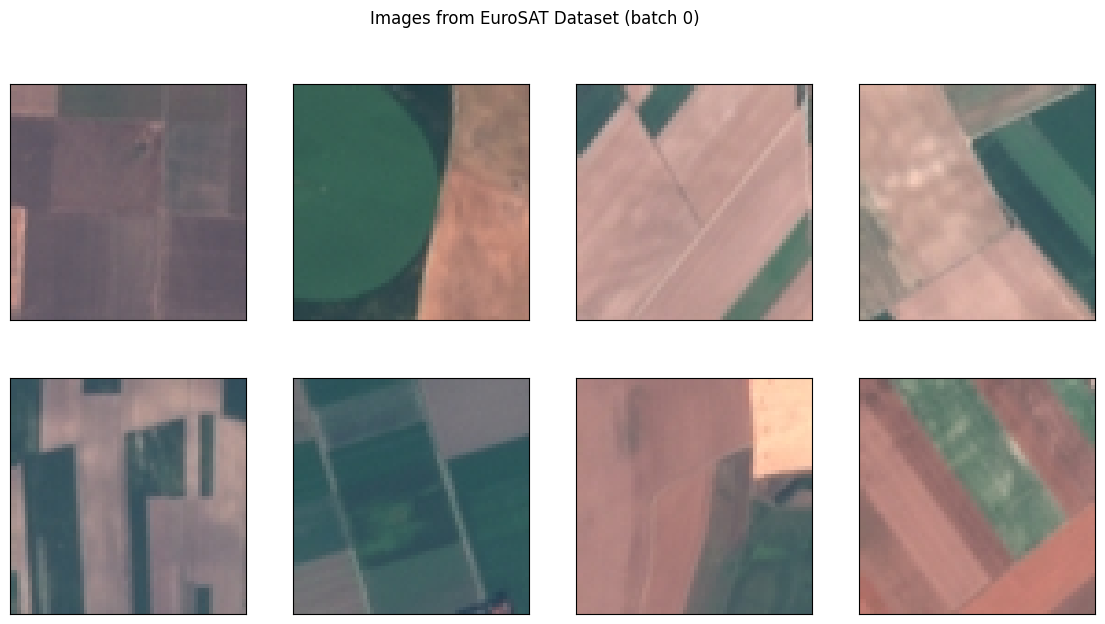

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

eurosat_dataset_og = datasets.EuroSAT("./eurosat_data", download=True, transform=transforms.ToTensor())
eurosat_loader_og = DataLoader(dataset=eurosat_dataset_og, batch_size=32, shuffle=False)

# visualise 8 images from the first batch in eurosatloader
for batch_idx, inputs in enumerate(eurosat_loader_og):
    fig = plt.figure(figsize=(14, 7))
    fig.suptitle('Images from EuroSAT Dataset (batch 0)')
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
        plt.imshow(inputs[0][i].numpy().transpose(1, 2, 0))
    break

In [ ]:
from tqdm import tqdm

image_size = 64

# compute dataset normalisation statistics
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(eurosat_loader_og):
    input_images = inputs[0]
    psum += input_images.sum(axis=[0, 2, 3])
    psum_sq += (input_images**2).sum(axis=[0, 2, 3])

# total pixel count (NxWxH)
count = len(eurosat_dataset_og) * image_size * image_size

# mean and std
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

# output
print("\nEuroSAT Normalisation Statistics")
print("mean: " + str(total_mean))
print("std:  " + str(total_std))

100%|██████████| 844/844 [00:12<00:00, 65.16it/s]


EuroSAT Normalisation Statistics
mean: tensor([0.3444, 0.3803, 0.4078])
std:  tensor([0.2027, 0.1369, 0.1156])


In [ ]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

from simple_cnn import Net, train, test
from dataset_utils import eurosatTransformation

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

num_epochs = 10
batch_size = 32

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {DEVICE} device")

# Create network architecture and send it to preferred device
simple_net = Net()
simple_net.to(DEVICE)

# Define a DataLoader for training and testing

# load the EuroSAT dataset
eurosat_dataset = datasets.EuroSAT("./eurosat_data", download=True, transform=eurosatTransformation())
eurosat_loader = DataLoader(dataset=eurosat_dataset, batch_size=32, shuffle=False)

print("\nPreprocessing EuroSAT dataset...\n")

print(eurosat_dataset)

trainset, testset = random_split(eurosat_dataset, [24000, 3000], torch.Generator().manual_seed(42))

print(f"\nLength of training set: {len(trainset)}")
print(f"Length of test set: {len(testset)}")

trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

print("\nTraining and test dataloaders created.")

# Check the accuracy of the model *before training*
test_loss, test_acc, num_test_samples = test(simple_net, testloader, device=DEVICE, log_progress=True)
print(f'\nBefore training: test_loss={test_loss:.4f}, test_accuracy={test_acc:.4f}, num_samples_tested={num_test_samples}')

Using cuda:0 device


100%|██████████| 94280567/94280567 [00:00<00:00, 115696222.77it/s]


Extracting ./eurosat_data/eurosat/EuroSAT.zip to ./eurosat_data/eurosat

Preprocessing EuroSAT dataset...

Dataset EuroSAT
    Number of datapoints: 27000
    Root location: ./eurosat_data
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.3444, 0.3803, 0.4078), std=(0.2027, 0.1369, 0.1156))
           )

Length of training set: 24000
Length of test set: 3000

Training and test dataloaders created.


TEST: 100%|██████████| 94/94 [00:02<00:00, 32.33it/s]




Before training: test_loss=0.0721, test_accuracy=0.1073, num_samples_tested=3000


### Normal Training (non-federated)

Training with simple CNN model

In [ ]:
# Train the model locally (no federated learning) for 25 epochs
for epoch in range(25):
    # Equivalently, can be rewritten as a single train(...) call with num_iterations=10 * len(trainloader)
    train_loss, train_acc, _ = train(net=simple_net,
                                     trainloader=trainloader,
                                     device=DEVICE,
                                     num_iterations=len(trainloader),
                                     optim='Adam')
    print(f'Epoch {epoch + 1}: train_loss={train_loss:.4f}, train_accuracy={train_acc:.4f}')

test_loss, test_acc, _ = test(simple_net, testloader, device=DEVICE, log_progress=True)
print(f'After training: test_loss={test_loss:.4f}, test_accuracy={test_acc:.4f}')

TRAIN: 100%|█████████▉| 749/750 [00:21<00:00, 35.35it/s, train_loss=0.024, train_acc=0.721]




Epoch 1: train_loss=0.0240, train_accuracy=0.7215


TRAIN: 100%|█████████▉| 749/750 [00:19<00:00, 39.21it/s, train_loss=0.02, train_acc=0.768]




Epoch 2: train_loss=0.0200, train_accuracy=0.7684


TRAIN: 100%|█████████▉| 749/750 [00:19<00:00, 39.40it/s, train_loss=0.0167, train_acc=0.806]




Epoch 3: train_loss=0.0167, train_accuracy=0.8063


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 37.17it/s, train_loss=0.0143, train_acc=0.835]




Epoch 4: train_loss=0.0143, train_accuracy=0.8349


TRAIN: 100%|█████████▉| 749/750 [00:19<00:00, 37.91it/s, train_loss=0.0119, train_acc=0.864]




Epoch 5: train_loss=0.0119, train_accuracy=0.8638


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 36.89it/s, train_loss=0.0101, train_acc=0.884]




Epoch 6: train_loss=0.0101, train_accuracy=0.8838


TRAIN: 100%|█████████▉| 749/750 [00:19<00:00, 37.95it/s, train_loss=0.00888, train_acc=0.899]




Epoch 7: train_loss=0.0089, train_accuracy=0.8986


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 36.92it/s, train_loss=0.00743, train_acc=0.917]




Epoch 8: train_loss=0.0074, train_accuracy=0.9169


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 37.11it/s, train_loss=0.00626, train_acc=0.929]




Epoch 9: train_loss=0.0063, train_accuracy=0.9295


TRAIN: 100%|█████████▉| 749/750 [00:22<00:00, 33.26it/s, train_loss=0.00529, train_acc=0.942]




Epoch 10: train_loss=0.0053, train_accuracy=0.9421


TRAIN: 100%|█████████▉| 749/750 [00:19<00:00, 37.81it/s, train_loss=0.00501, train_acc=0.946]




Epoch 11: train_loss=0.0050, train_accuracy=0.9464


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 36.30it/s, train_loss=0.00428, train_acc=0.954]




Epoch 12: train_loss=0.0043, train_accuracy=0.9537


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 37.24it/s, train_loss=0.00381, train_acc=0.959]




Epoch 13: train_loss=0.0038, train_accuracy=0.9593


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 36.24it/s, train_loss=0.00334, train_acc=0.965]




Epoch 14: train_loss=0.0033, train_accuracy=0.9646


TRAIN: 100%|█████████▉| 749/750 [00:19<00:00, 37.47it/s, train_loss=0.00341, train_acc=0.966]




Epoch 15: train_loss=0.0034, train_accuracy=0.9655


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 36.10it/s, train_loss=0.00276, train_acc=0.97]




Epoch 16: train_loss=0.0028, train_accuracy=0.9705


TRAIN: 100%|█████████▉| 749/750 [00:19<00:00, 37.63it/s, train_loss=0.00303, train_acc=0.968]




Epoch 17: train_loss=0.0030, train_accuracy=0.9685


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 36.92it/s, train_loss=0.0028, train_acc=0.971]




Epoch 18: train_loss=0.0028, train_accuracy=0.9713


TRAIN: 100%|█████████▉| 749/750 [00:21<00:00, 34.37it/s, train_loss=0.00273, train_acc=0.973]




Epoch 19: train_loss=0.0027, train_accuracy=0.9729


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 36.64it/s, train_loss=0.0026, train_acc=0.975]




Epoch 20: train_loss=0.0026, train_accuracy=0.9753


TRAIN: 100%|█████████▉| 749/750 [00:19<00:00, 38.83it/s, train_loss=0.00262, train_acc=0.973]




Epoch 21: train_loss=0.0026, train_accuracy=0.9730


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 36.81it/s, train_loss=0.00259, train_acc=0.975]




Epoch 22: train_loss=0.0026, train_accuracy=0.9753


TRAIN: 100%|█████████▉| 749/750 [00:19<00:00, 37.92it/s, train_loss=0.00226, train_acc=0.977]




Epoch 23: train_loss=0.0023, train_accuracy=0.9770


TRAIN: 100%|█████████▉| 749/750 [00:21<00:00, 35.33it/s, train_loss=0.00248, train_acc=0.975]




Epoch 24: train_loss=0.0025, train_accuracy=0.9753


TRAIN: 100%|█████████▉| 749/750 [00:20<00:00, 36.47it/s, train_loss=0.00238, train_acc=0.978]




Epoch 25: train_loss=0.0024, train_accuracy=0.9782


TEST: 100%|██████████| 94/94 [00:01<00:00, 48.39it/s]



After training: test_loss=0.0357, test_accuracy=0.8203

Saving model...


RuntimeError: Parent directory ./models does not exist.

In [ ]:
print("\nSaving model...")
torch.save(simple_net, 'simple_net')
print("Done.")


Saving model...
Done.


In [ ]:
loaded_net = torch.load('simple_net')

test_loss, test_acc, _ = test(loaded_net, testloader, device=DEVICE, log_progress=True)
print(f'After training: test_loss={test_loss:.4f}, test_accuracy={test_acc:.4f}')

TEST: 100%|██████████| 94/94 [00:02<00:00, 33.99it/s]



After training: test_loss=0.0357, test_accuracy=0.8203


Training with ResNet-50

SGD Optimizer

In [ ]:
from torchvision.models import resnet50

resnet = resnet50().to(DEVICE)

for epoch in range(25):
    # Equivalently, can be rewritten as a single train(...) call with num_iterations=10 * len(trainloader)
    train_loss, train_acc, _ = train(net=resnet, trainloader=trainloader, device=DEVICE, num_iterations=len(trainloader))
    print(f'Epoch {epoch + 1}: train_loss={train_loss:.4f}, train_accuracy={train_acc:.4f}')

test_loss, test_acc, _ = test(resnet, testloader, device=DEVICE, log_progress=True)
print(f'After training: test_loss={test_loss:.4f}, test_accuracy={test_acc:.4f}')

TRAIN: 100%|█████████▉| 749/750 [00:43<00:00, 17.19it/s, train_loss=0.0499, train_acc=0.453]




Epoch 1: train_loss=0.0499, train_accuracy=0.4532


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 18.07it/s, train_loss=0.0321, train_acc=0.645]




Epoch 2: train_loss=0.0321, train_accuracy=0.6451


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.71it/s, train_loss=0.0266, train_acc=0.701]




Epoch 3: train_loss=0.0266, train_accuracy=0.7010


TRAIN: 100%|█████████▉| 749/750 [00:40<00:00, 18.35it/s, train_loss=0.024, train_acc=0.734]




Epoch 4: train_loss=0.0240, train_accuracy=0.7341


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.87it/s, train_loss=0.0214, train_acc=0.76]




Epoch 5: train_loss=0.0214, train_accuracy=0.7598


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.75it/s, train_loss=0.0197, train_acc=0.779]




Epoch 6: train_loss=0.0197, train_accuracy=0.7792


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.97it/s, train_loss=0.0179, train_acc=0.803]




Epoch 7: train_loss=0.0179, train_accuracy=0.8033


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 18.03it/s, train_loss=0.0167, train_acc=0.814]




Epoch 8: train_loss=0.0167, train_accuracy=0.8142


TRAIN: 100%|█████████▉| 749/750 [00:40<00:00, 18.37it/s, train_loss=0.0151, train_acc=0.832]




Epoch 9: train_loss=0.0151, train_accuracy=0.8315


TRAIN: 100%|█████████▉| 749/750 [00:40<00:00, 18.54it/s, train_loss=0.0139, train_acc=0.846]




Epoch 10: train_loss=0.0139, train_accuracy=0.8458


TRAIN: 100%|█████████▉| 749/750 [00:40<00:00, 18.56it/s, train_loss=0.013, train_acc=0.856]




Epoch 11: train_loss=0.0130, train_accuracy=0.8561


TRAIN: 100%|█████████▉| 749/750 [00:40<00:00, 18.33it/s, train_loss=0.012, train_acc=0.868]




Epoch 12: train_loss=0.0120, train_accuracy=0.8676


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 18.02it/s, train_loss=0.0109, train_acc=0.88]




Epoch 13: train_loss=0.0109, train_accuracy=0.8805


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.75it/s, train_loss=0.00999, train_acc=0.89]




Epoch 14: train_loss=0.0100, train_accuracy=0.8899


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.83it/s, train_loss=0.00972, train_acc=0.892]




Epoch 15: train_loss=0.0097, train_accuracy=0.8921


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.70it/s, train_loss=0.0085, train_acc=0.907]




Epoch 16: train_loss=0.0085, train_accuracy=0.9075


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.90it/s, train_loss=0.00757, train_acc=0.917]




Epoch 17: train_loss=0.0076, train_accuracy=0.9167


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.98it/s, train_loss=0.00712, train_acc=0.92]




Epoch 18: train_loss=0.0071, train_accuracy=0.9204


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.95it/s, train_loss=0.0067, train_acc=0.926]




Epoch 19: train_loss=0.0067, train_accuracy=0.9262


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.99it/s, train_loss=0.00608, train_acc=0.933]




Epoch 20: train_loss=0.0061, train_accuracy=0.9330


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.65it/s, train_loss=0.00535, train_acc=0.939]




Epoch 21: train_loss=0.0053, train_accuracy=0.9388


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.61it/s, train_loss=0.00506, train_acc=0.943]




Epoch 22: train_loss=0.0051, train_accuracy=0.9435


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.49it/s, train_loss=0.00491, train_acc=0.946]




Epoch 23: train_loss=0.0049, train_accuracy=0.9461


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.67it/s, train_loss=0.00448, train_acc=0.952]




Epoch 24: train_loss=0.0045, train_accuracy=0.9523


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.79it/s, train_loss=0.00417, train_acc=0.955]




Epoch 25: train_loss=0.0042, train_accuracy=0.9550


TEST: 100%|██████████| 94/94 [00:02<00:00, 32.70it/s]



After training: test_loss=0.0196, test_accuracy=0.8320


Adam Optimizer

In [ ]:
from torchvision.models import resnet50

resnet = resnet50().to(DEVICE)

for epoch in range(25):
    # Equivalently, can be rewritten as a single train(...) call with num_iterations=10 * len(trainloader)
    train_loss, train_acc, _ = train(net=resnet,
                                     trainloader=trainloader,
                                     device=DEVICE,
                                     num_iterations=len(trainloader),
                                     optim='Adam')
    print(f'Epoch {epoch + 1}: train_loss={train_loss:.4f}, train_accuracy={train_acc:.4f}')

test_loss, test_acc, _ = test(resnet, testloader, device=DEVICE, log_progress=True)
print(f'After training: test_loss={test_loss:.4f}, test_accuracy={test_acc:.4f}')


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.61it/s, train_loss=0.0418, train_acc=0.562]




Epoch 1: train_loss=0.0418, train_accuracy=0.5618


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.72it/s, train_loss=0.0308, train_acc=0.659]




Epoch 2: train_loss=0.0308, train_accuracy=0.6592


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.53it/s, train_loss=0.0238, train_acc=0.735]




Epoch 3: train_loss=0.0238, train_accuracy=0.7350


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.46it/s, train_loss=0.0198, train_acc=0.783]




Epoch 4: train_loss=0.0198, train_accuracy=0.7833


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.70it/s, train_loss=0.0178, train_acc=0.805]




Epoch 5: train_loss=0.0178, train_accuracy=0.8055


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.78it/s, train_loss=0.0146, train_acc=0.839]




Epoch 6: train_loss=0.0146, train_accuracy=0.8392


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 18.07it/s, train_loss=0.0139, train_acc=0.85]




Epoch 7: train_loss=0.0139, train_accuracy=0.8502


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.64it/s, train_loss=0.0113, train_acc=0.876]




Epoch 8: train_loss=0.0113, train_accuracy=0.8760


TRAIN: 100%|█████████▉| 749/750 [00:43<00:00, 17.29it/s, train_loss=0.00972, train_acc=0.892]




Epoch 9: train_loss=0.0097, train_accuracy=0.8924


TRAIN: 100%|█████████▉| 749/750 [00:43<00:00, 17.38it/s, train_loss=0.00863, train_acc=0.903]




Epoch 10: train_loss=0.0086, train_accuracy=0.9030


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.49it/s, train_loss=0.00766, train_acc=0.915]




Epoch 11: train_loss=0.0077, train_accuracy=0.9151


TRAIN: 100%|█████████▉| 749/750 [00:43<00:00, 17.27it/s, train_loss=0.00683, train_acc=0.925]




Epoch 12: train_loss=0.0068, train_accuracy=0.9251


TRAIN: 100%|█████████▉| 749/750 [00:43<00:00, 17.16it/s, train_loss=0.00616, train_acc=0.931]




Epoch 13: train_loss=0.0062, train_accuracy=0.9315


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.44it/s, train_loss=0.0056, train_acc=0.939]




Epoch 14: train_loss=0.0056, train_accuracy=0.9385


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.61it/s, train_loss=0.00533, train_acc=0.941]




Epoch 15: train_loss=0.0053, train_accuracy=0.9406


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.71it/s, train_loss=0.00464, train_acc=0.948]




Epoch 16: train_loss=0.0046, train_accuracy=0.9481


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.61it/s, train_loss=0.00533, train_acc=0.942]




Epoch 17: train_loss=0.0053, train_accuracy=0.9419


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.81it/s, train_loss=0.00418, train_acc=0.954]




Epoch 18: train_loss=0.0042, train_accuracy=0.9536


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.78it/s, train_loss=0.00389, train_acc=0.958]




Epoch 19: train_loss=0.0039, train_accuracy=0.9584


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 18.03it/s, train_loss=0.00373, train_acc=0.958]




Epoch 20: train_loss=0.0037, train_accuracy=0.9583


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.94it/s, train_loss=0.00329, train_acc=0.965]




Epoch 21: train_loss=0.0033, train_accuracy=0.9655


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.87it/s, train_loss=0.00306, train_acc=0.967]




Epoch 22: train_loss=0.0031, train_accuracy=0.9670


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.88it/s, train_loss=0.00281, train_acc=0.969]




Epoch 23: train_loss=0.0028, train_accuracy=0.9691


TRAIN: 100%|█████████▉| 749/750 [00:42<00:00, 17.73it/s, train_loss=0.00246, train_acc=0.973]




Epoch 24: train_loss=0.0025, train_accuracy=0.9730


TRAIN: 100%|█████████▉| 749/750 [00:41<00:00, 17.89it/s, train_loss=0.00241, train_acc=0.974]




Epoch 25: train_loss=0.0024, train_accuracy=0.9744


TEST: 100%|██████████| 94/94 [00:02<00:00, 35.20it/s]



After training: test_loss=0.0080, test_accuracy=0.9250


Writing client.py


Writing server.py


In [ ]:
from dataset_utils import get_eurosat
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
training_path, test_set = get_eurosat()

100%|██████████| 94280567/94280567 [00:08<00:00, 11542491.78it/s]


Extracting ./eurosat_data/eurosat/EuroSAT.zip to ./eurosat_data/eurosat


In [ ]:
print(training_path)
print(len(test_set))

eurosat_data/eurosat/training.pt
3000


### Experiments

In federated learning, the server orchestrates the experiment by instructing chosen clients to start training and then aggregating the results. We can control the behavior of the server (and the clients) through a set of parameters. Go through the following list, taking care to understand each parameter (refer back to the code if necessary).

--num-rounds: the number of rounds in the FL experiment

--client-pool-size: the number of clients made available to an FL round

--num-iterations: the number of iterations/updates a client performs per round (single local epoch if None). We will vary the client pool size in further experiments, which makes the number of local epochs an ambiguous target for training (more clients -> less data per client -> shorter local epochs), so we use the number of training iterations/updates, instead. However, if you're used to thinking of training in terms of number of epochs, you can compute how many examples would consistute N local epochs for a particular configuration:

CIFAR-10 consists of 50000 training examples (distributed to clients) and 10000 test examples (kept on the server);
with 10 clients, each client receives 50000/10 = 5000 examples as its local dataset;
val-ratio fraction of the data (e.g. 0.1) is reserved for a local test set, giving a 4500/500 split;
at batch size of 32, we need ceil(4500 / 32) = 141 updates to go through the entire training set;
thus, N local epochs would correspond 141 * N iterations/updates, with the parameters assumed above.
--fraction-fit: a fraction of clients that should be sampled for each round (0.0, 1.0].

--min-fit-clients: the minimum number of clients to participate in a fitting round (will override if the number produced via --fraction_fit is smaller than --min-fit-clients).

--batch-size: batch size for a client fitting round

--val-ratio : a proportion of local data to reserve as a local test set

--iid-alpha: (LDA prior concentration parameter for data partitioning). In practice, use a large --iid-alpha to make data IID across clients (all classes equally represented across all clients); a small value (e.g. 1) will make it non-IID (clients will hold data mostly belonging to one class). The script prints a class histogram for the first (0th) client as an example.

#### Experiment 0 - Test FL Pipeline

In [ ]:
!python server.py --client-pool-size 2 --num-iterations 1000 --num-rounds 10 --val-ratio 0.0

Class histogram for 0-th partition (alpha=1000.0, 10 classes): [1322 1403 1325 1320 1289 1393 1335 1417 1441 1255]
Data partitioned across 2 clients, with IID alpha = 1000.0 and 0.0 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 2 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-11 09:51:19,146 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-11 09:51:23,248 | app.py:176 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'accelerator_type:V100': 1.0, 'object_store_memory': 3493215436.0, 'memory': 6986430875.0, 'CPU': 2.0, 'GPU': 1.0}
INFO flower 2024-01-11 09:51:23,248 | server.py:86 | Initializing global parameters
INFO flower 2024-01-11 09:51:23,252 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-11 09:51:26,265 | server.py:274 | Received initial parameters 

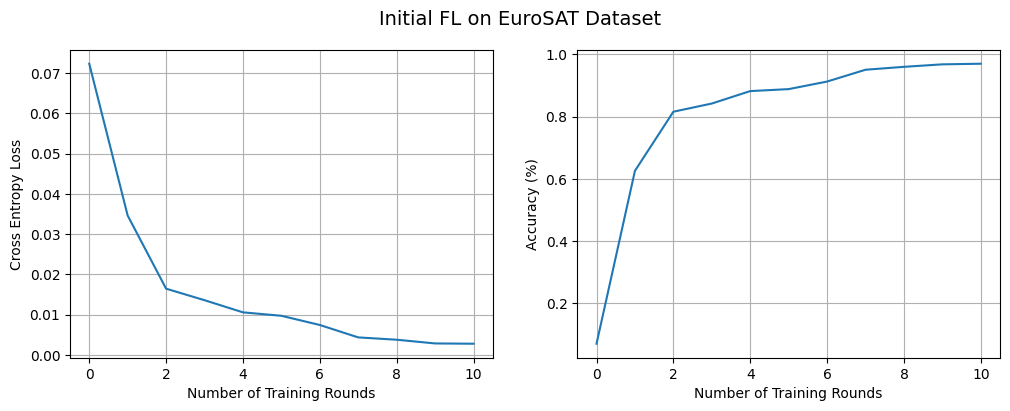

In [ ]:
import matplotlib.pyplot as plt

loss_vals = [0.0723067488670349,
             0.034594989041487376,
             0.016428479924798012,
             0.013567370881636938,
             0.010551592032114665,
             0.009697937866051992,
             0.007409338408460219,
             0.004327420454472304,
             0.003748844251657526,
             0.0028285741992294788,
             0.002757666856671373]

acc_vals = [0.07,
            0.626,
            0.816,
            0.8423333333333334,
            0.8823333333333333,
            0.8886666666666667,
            0.913,
            0.951,
            0.9603333333333334,
            0.9683333333333334,
            0.9703333333333334]


fig = plt.figure(figsize=(12,4))
fig.suptitle('Initial FL on EuroSAT Dataset', fontsize=14)
axarr = fig.subplots(1,2)

axarr[0].plot(loss_vals), axarr[0].set(xlabel='Number of Training Rounds', ylabel='Cross Entropy Loss'), axarr[0].grid('on')
axarr[1].plot(acc_vals), axarr[1].set(xlabel='Number of Training Rounds', ylabel='Accuracy (%)'), axarr[1].grid('on');

### Experiment 1: Changing the number of clients

Running FL with [2, 5, 10, 20] clients

In [ ]:
!python server.py --client-pool-size 2 --num-iterations 1000 --num-rounds 10 --val-ratio 0.1

Class histogram for 0-th partition (alpha=1000.0, 10 classes): [1295 1371 1378 1331 1334 1377 1343 1357 1395 1319]
Data partitioned across 2 clients, with IID alpha = 1000.0 and 0.1 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 2 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-15 22:41:45,574 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-15 22:41:49,832 | app.py:176 | Flower VCE: Ray initialized with resources: {'accelerator_type:V100': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3478579200.0, 'memory': 6957158400.0}
INFO flower 2024-01-15 22:41:49,832 | server.py:86 | Initializing global parameters
INFO flower 2024-01-15 22:41:49,832 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-15 22:41:53,324 | server.py:274 | Received initial parameters 

In [ ]:
!python server.py --client-pool-size 5 --num-iterations 1000 --num-rounds 10 --val-ratio 0.1

Class histogram for 0-th partition (alpha=1000.0, 10 classes): [558 511 508 547 549 536 537 576 563 515]
Data partitioned across 5 clients, with IID alpha = 1000.0 and 0.1 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 5 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-15 22:56:40,324 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-15 22:56:44,302 | app.py:176 | Flower VCE: Ray initialized with resources: {'memory': 7046836224.0, 'CPU': 2.0, 'accelerator_type:V100': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3523418112.0, 'GPU': 1.0}
INFO flower 2024-01-15 22:56:44,302 | server.py:86 | Initializing global parameters
INFO flower 2024-01-15 22:56:44,302 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-15 22:56:47,137 | server.py:274 | Received initial parameters from one r

In [ ]:
!python server.py --client-pool-size 10 --num-iterations 1000 --num-rounds 10 --val-ratio 0.1

Class histogram for 0-th partition (alpha=1000.0, 10 classes): [270 268 279 253 277 275 254 277 274 273]
Data partitioned across 10 clients, with IID alpha = 1000.0 and 0.1 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 10 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-15 23:17:29,453 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-15 23:17:33,663 | app.py:176 | Flower VCE: Ray initialized with resources: {'accelerator_type:V100': 1.0, 'GPU': 1.0, 'memory': 7117878068.0, 'CPU': 2.0, 'object_store_memory': 3558939033.0, 'node:172.28.0.12': 1.0}
INFO flower 2024-01-15 23:17:33,663 | server.py:86 | Initializing global parameters
INFO flower 2024-01-15 23:17:33,664 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-15 23:17:37,576 | server.py:274 | Received initial parameters from one

KeyboardInterrupt: 

In [ ]:
!python server.py --client-pool-size 25 --num-iterations 1000 --num-rounds 10 --val-ratio 0.1

### Experiment 2: Changing the number of concurrent clients

Total number of clients: 25

Running FL with [2/25, 5/25, 10/25, 20/25] concurrent clients

In [ ]:
!python server.py --fraction-fit 0.08 --min-fit-clients 2 --client-pool-size 25 --num-iterations 1000 --num-rounds 10 --val-ratio 0.1

Class histogram for 0-th partition (alpha=1000.0, 10 classes): [103  95 109  99 123 110 101 115 115 110]
Data partitioned across 25 clients, with IID alpha = 1000.0 and 0.1 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 25 client in the pool.
FL round will proceed with 8.0% of clients sampled, at least 2.
INFO flower 2024-01-12 21:23:01,422 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-12 21:23:05,391 | app.py:176 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3597233356.0, 'GPU': 1.0, 'memory': 7194466715.0, 'accelerator_type:V100': 1.0}
INFO flower 2024-01-12 21:23:05,392 | server.py:86 | Initializing global parameters
INFO flower 2024-01-12 21:23:05,392 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-12 21:23:08,180 | server.py:274 | Received initial parameters from one r

In [ ]:
!python server.py --fraction-fit 0.20 --min-fit-clients 5 --client-pool-size 25 --num-iterations 1000 --num-rounds 10 --val-ratio 0.1

Class histogram for 0-th partition (alpha=1000.0, 10 classes): [102  92 119 102 115 110 103 119 113 105]
Data partitioned across 25 clients, with IID alpha = 1000.0 and 0.1 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 25 client in the pool.
FL round will proceed with 20.0% of clients sampled, at least 5.
INFO flower 2024-01-12 21:36:27,415 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-12 21:36:31,520 | app.py:176 | Flower VCE: Ray initialized with resources: {'memory': 7200581223.0, 'object_store_memory': 3600290611.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'accelerator_type:V100': 1.0, 'GPU': 1.0}
INFO flower 2024-01-12 21:36:31,520 | server.py:86 | Initializing global parameters
INFO flower 2024-01-12 21:36:31,522 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-12 21:36:34,462 | server.py:274 | Received initial parameters from one 

In [ ]:
!python server.py --fraction-fit 0.40 --min-fit-clients 10 --client-pool-size 25 --num-iterations 1000 --num-rounds 10 --val-ratio 0.1

Class histogram for 0-th partition (alpha=1000.0, 10 classes): [104  96 121 102 114 106  96 123 103 115]
Data partitioned across 25 clients, with IID alpha = 1000.0 and 0.1 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 25 client in the pool.
FL round will proceed with 40.0% of clients sampled, at least 10.
INFO flower 2024-01-12 22:13:22,932 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-12 22:13:27,371 | app.py:176 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'accelerator_type:V100': 1.0, 'GPU': 1.0, 'CPU': 2.0, 'memory': 7263139431.0, 'object_store_memory': 3631569715.0}
INFO flower 2024-01-12 22:13:27,372 | server.py:86 | Initializing global parameters
INFO flower 2024-01-12 22:13:27,372 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-12 22:13:31,166 | server.py:274 | Received initial parameters from one

In [ ]:
!python server.py --fraction-fit 0.80 --min-fit-clients 20 --client-pool-size 25 --num-iterations 1000 --num-rounds 10 --val-ratio 0.1

Class histogram for 0-th partition (alpha=1000.0, 10 classes): [103  88 114 114 117 110  98 124 114  98]
Data partitioned across 25 clients, with IID alpha = 1000.0 and 0.1 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 25 client in the pool.
FL round will proceed with 80.0% of clients sampled, at least 20.
INFO flower 2024-01-13 11:10:12,358 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-13 11:10:16,511 | app.py:176 | Flower VCE: Ray initialized with resources: {'memory': 6987322983.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3493661491.0, 'accelerator_type:V100': 1.0, 'CPU': 2.0}
INFO flower 2024-01-13 11:10:16,512 | server.py:86 | Initializing global parameters
INFO flower 2024-01-13 11:10:16,512 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-13 11:10:19,754 | server.py:274 | Received initial parameters from one

### Experiment 3: Changing the iid-ness of the data

Total number of clients: 10

Running FL with iid-alpha={0.2, 0.5, 2.0, 5.0, 10.0, 100.0, 1000} concurrent clients

In [ ]:
!python server.py --iid-alpha 0.2 --fraction-fit 1.0 --client-pool-size 10 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=0.2, 10 classes): [  0 137 949 251 310   0   8 118   0 927]
Data partitioned across 10 clients, with IID alpha = 0.2 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 10 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-14 08:26:01,082 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-14 08:26:05,260 | app.py:176 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'object_store_memory': 3480791040.0, 'memory': 6961582080.0, 'CPU': 2.0, 'accelerator_type:V100': 1.0, 'GPU': 1.0}
INFO flower 2024-01-14 08:26:05,260 | server.py:86 | Initializing global parameters
INFO flower 2024-01-14 08:26:05,260 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-14 08:26:09,849 | server.py:274 | Received initial parameters from one rando

In [ ]:
!python server.py --iid-alpha 0.5 --fraction-fit 1.0 --client-pool-size 10 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=0.5, 10 classes): [   2  108  230    2   52    8   97   12  799 1390]
Data partitioned across 10 clients, with IID alpha = 0.5 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 10 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-14 09:44:11,575 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-14 09:44:16,576 | app.py:176 | Flower VCE: Ray initialized with resources: {'accelerator_type:V100': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0, 'object_store_memory': 3478811443.0, 'memory': 6957622887.0}
INFO flower 2024-01-14 09:44:16,576 | server.py:86 | Initializing global parameters
INFO flower 2024-01-14 09:44:16,576 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-14 09:44:20,821 | server.py:274 | Received initial parameters from

In [ ]:
!python server.py --iid-alpha 2 --fraction-fit 1.0 --client-pool-size 10 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=2.0, 10 classes): [357 251 338 264  86 323 369 258 209 245]
Data partitioned across 10 clients, with IID alpha = 2.0 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 10 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-14 12:21:00,709 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-14 12:21:05,848 | app.py:176 | Flower VCE: Ray initialized with resources: {'accelerator_type:V100': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 6995187303.0, 'CPU': 2.0, 'object_store_memory': 3497593651.0}
INFO flower 2024-01-14 12:21:05,848 | server.py:86 | Initializing global parameters
INFO flower 2024-01-14 12:21:05,848 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-14 12:21:09,725 | server.py:274 | Received initial parameters from one rando

In [ ]:
!python server.py --iid-alpha 5 --fraction-fit 1.0 --client-pool-size 10 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=5.0, 10 classes): [377 219 449 305  96 283 259 173 168 371]
Data partitioned across 10 clients, with IID alpha = 5.0 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 10 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-14 13:35:12,208 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-14 13:35:17,114 | app.py:176 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'accelerator_type:V100': 1.0, 'memory': 6999549543.0, 'object_store_memory': 3499774771.0, 'CPU': 2.0}
INFO flower 2024-01-14 13:35:17,115 | server.py:86 | Initializing global parameters
INFO flower 2024-01-14 13:35:17,115 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-14 13:35:20,803 | server.py:274 | Received initial parameters from one rando

In [ ]:
!python server.py --iid-alpha 10 --fraction-fit 1.0 --client-pool-size 10 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=10.0, 10 classes): [299 279 166 220 311 242 293 185 383 322]
Data partitioned across 10 clients, with IID alpha = 10.0 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 10 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-14 14:50:53,603 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-14 14:50:57,768 | app.py:176 | Flower VCE: Ray initialized with resources: {'accelerator_type:V100': 1.0, 'object_store_memory': 3530808115.0, 'memory': 7061616231.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'GPU': 1.0}
INFO flower 2024-01-14 14:50:57,776 | server.py:86 | Initializing global parameters
INFO flower 2024-01-14 14:50:57,776 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-14 14:51:00,371 | server.py:274 | Received initial parameters from one ran

In [ ]:
!python server.py --iid-alpha 100 --fraction-fit 1.0 --client-pool-size 10 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=100.0, 10 classes): [279 272 281 248 292 276 243 292 244 273]
Data partitioned across 10 clients, with IID alpha = 100.0 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 10 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-14 16:04:38,731 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-14 16:04:42,755 | app.py:176 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 3572390707.0, 'CPU': 2.0, 'accelerator_type:V100': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7144781415.0}
INFO flower 2024-01-14 16:04:42,756 | server.py:86 | Initializing global parameters
INFO flower 2024-01-14 16:04:42,756 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-14 16:04:45,564 | server.py:274 | Received initial parameters from one r

In [ ]:
!python server.py --iid-alpha 1000 --fraction-fit 1.0 --client-pool-size 10 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=1000.0, 10 classes): [268 273 279 261 270 265 260 280 272 272]
Data partitioned across 10 clients, with IID alpha = 1000.0 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 10 client in the pool.
FL round will proceed with 100.0% of clients sampled, at least 2.
INFO flower 2024-01-14 16:58:43,446 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-14 16:58:47,541 | app.py:176 | Flower VCE: Ray initialized with resources: {'memory': 6975873024.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3487936512.0, 'GPU': 1.0, 'accelerator_type:V100': 1.0}
INFO flower 2024-01-14 16:58:47,542 | server.py:86 | Initializing global parameters
INFO flower 2024-01-14 16:58:47,542 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-14 16:58:50,191 | server.py:274 | Received initial parameters from one

In [ ]:
!python server.py --iid-alpha 10 --fraction-fit 0.3 --client-pool-size 10 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=10.0, 10 classes): [238 191 289 319 380 389 143 353 220 178]
Data partitioned across 10 clients, with IID alpha = 10.0 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 10 client in the pool.
FL round will proceed with 30.0% of clients sampled, at least 2.
INFO flower 2024-01-15 16:59:31,688 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-15 16:59:36,521 | app.py:176 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'accelerator_type:V100': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3484237824.0, 'memory': 6968475648.0}
INFO flower 2024-01-15 16:59:36,521 | server.py:86 | Initializing global parameters
INFO flower 2024-01-15 16:59:36,521 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-15 16:59:39,592 | server.py:274 | Received initial parameters from one rand

In [ ]:
!python server.py --iid-alpha 10 --fraction-fit 0.3 --client-pool-size 8 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=10.0, 10 classes): [515 197 362 130 318 386 414 216 449 388]
Data partitioned across 8 clients, with IID alpha = 10.0 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 8 client in the pool.
FL round will proceed with 30.0% of clients sampled, at least 2.
INFO flower 2024-01-15 18:09:32,568 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-15 18:09:36,448 | app.py:176 | Flower VCE: Ray initialized with resources: {'accelerator_type:V100': 1.0, 'object_store_memory': 3495331430.0, 'memory': 6990662862.0, 'GPU': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0}
INFO flower 2024-01-15 18:09:36,450 | server.py:86 | Initializing global parameters
INFO flower 2024-01-15 18:09:36,450 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-15 18:09:39,375 | server.py:274 | Received initial parameters from one random

In [ ]:
!python server.py --iid-alpha 10 --fraction-fit 0.3 --client-pool-size 8 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=10.0, 10 classes): [296 302 277 350 270 353 457 333 167 570]
Data partitioned across 8 clients, with IID alpha = 10.0 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 8 client in the pool.
FL round will proceed with 30.0% of clients sampled, at least 2.
INFO flower 2024-01-15 21:47:19,565 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-15 21:47:23,842 | app.py:176 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3485057433.0, 'accelerator_type:V100': 1.0, 'memory': 6970114868.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flower 2024-01-15 21:47:23,843 | server.py:86 | Initializing global parameters
INFO flower 2024-01-15 21:47:23,843 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-15 21:47:26,890 | server.py:274 | Received initial parameters from one random

### Final Experiment

1. Changing iid-alpha from 0.2, 2, 10, 1000

2. Total Clients: 10

3. Random numbers of concurrent clients sampled each round

Metrics each round:
  - Acc
  - Class OvR precisions and recalls
  - Loss

In [ ]:
!python server.py --iid-alpha 0.2 --fraction-fit 0.3 --client-pool-size 8 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=0.2, 10 classes): [   7    0  124   25   12 1066    0  408  344 1389]
Data partitioned across 8 clients, with IID alpha = 0.2 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 8 client in the pool.
FL round will proceed with 30.0% of clients sampled, at least 2.
INFO flower 2024-01-15 23:37:22,412 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-15 23:37:26,015 | app.py:176 | Flower VCE: Ray initialized with resources: {'memory': 7212611175.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'accelerator_type:V100': 1.0, 'GPU': 1.0, 'object_store_memory': 3606305587.0}
INFO flower 2024-01-15 23:37:26,016 | server.py:86 | Initializing global parameters
INFO flower 2024-01-15 23:37:26,016 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-15 23:37:29,038 | server.py:274 | Received initial parameters from on

In [ ]:
!python server.py --iid-alpha 0.5 --fraction-fit 0.3 --client-pool-size 8 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

Class histogram for 0-th partition (alpha=0.5, 10 classes): [215 414 910  37  22 270   4 364 710 429]
Data partitioned across 8 clients, with IID alpha = 0.5 and 0.2 of local dataset reserved for validation.
FL experiment configured for 10 rounds with 8 client in the pool.
FL round will proceed with 30.0% of clients sampled, at least 2.
INFO flower 2024-01-16 00:11:23,149 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2024-01-16 00:11:26,762 | app.py:176 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3627212390.0, 'node:172.28.0.12': 1.0, 'accelerator_type:V100': 1.0, 'GPU': 1.0, 'memory': 7254424782.0}
INFO flower 2024-01-16 00:11:26,763 | server.py:86 | Initializing global parameters
INFO flower 2024-01-16 00:11:26,763 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2024-01-16 00:11:29,626 | server.py:274 | Received initial parameters from one random c

In [ ]:
!python server.py --iid-alpha 2 --fraction-fit 0.3 --client-pool-size 8 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

In [ ]:
!python server.py --iid-alpha 5 --fraction-fit 0.3 --client-pool-size 8 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

In [ ]:
!python server.py --iid-alpha 10 --fraction-fit 0.3 --client-pool-size 8 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

In [ ]:
!python server.py --iid-alpha 100 --fraction-fit 0.3 --client-pool-size 8 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2

In [ ]:
!python server.py --iid-alpha 10 --fraction-fit 0.3 --client-pool-size 8 --num-iterations 1000 --num-rounds 10 --val-ratio 0.2